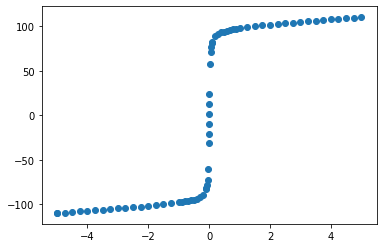

Figure 1: plot of magnetization data


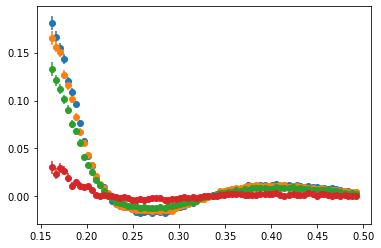

Figure 2: plot of SANS data
[[Variables]]
    mudc_1:     12.8375073 +/- 0.05428243 (0.42%) (init = 12)
    muds_1:     41.5649204 +/- 0.05189378 (0.12%) (init = 40)
    sigmads_1:  0.12 (fixed)
    sigmadc_1:  0.08 (fixed)
    rhos_1:     2.8 (fixed)
    MSFe_1:     94.1474758 +/- 0.35702708 (0.38%) (init = 100)
    CC_1:       1.47512511 +/- 0.03198725 (2.17%) (init = 1)
    B_1:        5 (fixed)
    B_2:        1 (fixed)
    B_3:        0.1 (fixed)
    B_4:        0.00605361 +/- 5.2275e-04 (8.64%) (init = 0.0073)
    mudc_5:     12.8375073 +/- 0.05428243 (0.42%) == 'mudc_1'
    sigmadc_5:  0.08000000 +/- 0.00000000 (0.00%) == 'sigmadc_1'
    MSFe_5:     94.1474758 +/- 0.35702708 (0.38%) == 'MSFe_1'
    b:          3.56864969 +/- 0.14394989 (4.03%) (init = 1)
    mudc_2:     12.8375073 +/- 0.05428243 (0.42%) == 'mudc_1'
    muds_2:     41.5649204 +/- 0.05189378 (0.12%) == 'muds_1'
    sigmads_2:  0.12000000 +/- 0.00000000 (0.00%) == 'sigmads_1'
    sigmadc_2:  0.08000000 +/- 0.000000

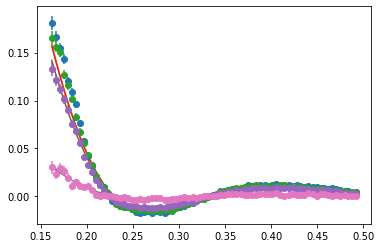

Figure A.1: plot of SANS data and fit (least-squares fit)


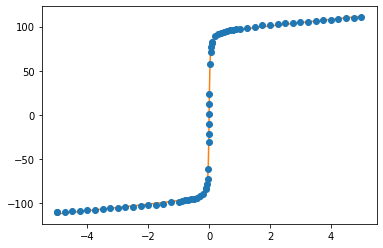

Figure A.2: plot of DCMdata and fit (least-squares fit)


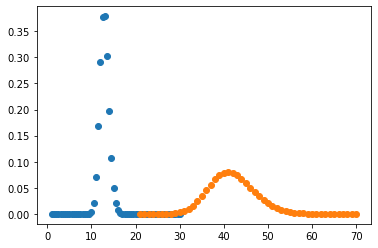

Figure A.3: lognormal distribution of core (blue) and total particle (orange) size (least-squares fit)


In [1]:
# In this notebook the size distributions are extracted from a global fit of the
# field-dependent nuclear-magnetic SANS cross terms and the isothermal magnetization curve
# of a sample of superparamagnetic core-shell iron oxide nanoparticles (surrounded by a silica shell).
# We assume here (i) lognormal distributions for the core and total particle size, and that
# (ii) the iron oxide cores are homogeneously magnetized (i.e. magnetic = nuclear core size). 
# The field-dependent SANS data is fitted with a combination of the form factor for spheres (magnetic part) 
# and the form factor for spherical core-shell particles (nuclear part).
# The magnetization curve is fitted with the Langevin function. For the data refinement we first fit
# the data with a standard least-squares approach and then use the fit values as starting points
# for the data refinement with a Bayesian approach to obtain the posterior probabilities and
# cross-correlations for all free fit parameters.
# The results are published in: 
# "The benefits of a Bayesian analysis for the characterization of magnetic nanoparticles"
# https://arxiv.org/abs/2005.09325

#==============================================================================
# Import of used packages

import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
import corner
import emcee

k = 1.381 * pow(10,-23) # Boltzman constant [J/K]
T0 = 300. # Temperature [K]
rho = 4860. # Density of iron oxide [kg/m^3]
Wscale = 0.7 # Weight percentage iron in iron oxide

#==============================================================================
# Import of data

q,Iq1,sd1=np.genfromtxt("../data/SANS-5T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(0,1,2)) # 5T
Iq2,sd2=np.genfromtxt("../data/SANS-1T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(1,2)) # 1T
Iq3,sd3=np.genfromtxt("../data/SANS-0.1T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(1,2)) # 0.1T
Iq4,sd4=np.genfromtxt("../data/SANS-0.02T_data.txt",unpack=True,skip_header=0,skip_footer=0,usecols=(1,2)) # 0.02T

Bm,m=np.genfromtxt("../data/Magnetization_data.txt", unpack=True, usecols = (0, 1), skip_header=0, skip_footer=0) # 1. branch
sdm=0.1*np.sqrt(abs(m)) # Standard error of measurement is much lower than actual measurement uncertainty. 
                        # Here, we assume 0.1*np.sqrt(abs(m)) to be a reasonable estimate for sigma.

Nm=len(m)
Nq=len(q)

#==============================================================================
# Plot of the data

plt.errorbar(Bm,m,sdm, marker='o', ls='None', label='Observed')
plt.show()
print('Figure 1: plot of magnetization data')

plt.errorbar(q,Iq1,sd1, marker='o', ls='None', label='Observed')
plt.errorbar(q,Iq2,sd2, marker='o', ls='None', label='Observed')
plt.errorbar(q,Iq3,sd3, marker='o', ls='None', label='Observed')
plt.errorbar(q,Iq4,sd4, marker='o', ls='None', label='Observed')
plt.xscale('linear')
plt.yscale('linear')
plt.show()
print('Figure 2: plot of SANS data')

#==============================================================================
# Create dictionaries for global fit

data = []
data.append(Iq1)
data.append(Iq2)
data.append(Iq3)
data.append(Iq4)

# Dictionary sd is written in list sddata

sddata = []
sddata.append(sd1)
sddata.append(sd2)
sddata.append(sd3)
sddata.append(sd4)

N=4

# data and sddata lists are transferred in array

data = np.array(data)
assert(data.shape) == (N, Nq)

sddata = np.array(sddata)
assert(sddata.shape) == (N, Nq)

#==============================================================================
# Definition of the fitting functions

def lognor(d,sigma,mu): # lognormal distribution 
    return 1./(np.sqrt(2.*np.pi)*sigma*d)*np.exp(-0.5*pow((np.log(d)-np.log(mu))/sigma,2))          

def V(d): # volume
    return 1./6.*np.pi*pow(d,3)

def MS(MSFe): # saturation magnetization in [A/m]
    return MSFe*rho*Wscale

def xi(B,d,MSFe): # Langevin parameter
    return B*MS(MSFe)*V(d)*pow(10,-27)/(k*T0) 

def L(B,d,MSFe): # Langevin function
    return (1./np.tanh(xi(B,d,MSFe))-1./xi(B,d,MSFe))   

def rhom(B,d,MSFe,CC):
    return MS(MSFe)*V(d)*L(B,d,MSFe)*CC*pow(10,-10)

def FormNuc(q,ds,dc,rhos,rhoc): # (nuclear) form factor for core-shell spheres, index c = core, index s = shell
    return (3.*V(dc)*(rhoc-rhos)*pow(10,-6)*(np.sin(q*dc*0.5)-q*dc*0.5*np.cos(q*dc*0.5))/pow(q*dc*0.5,3)
            +3.*V(ds)*rhos*pow(10,-6)*(np.sin(q*ds*0.5)-q*ds*0.5*np.cos(q*ds*0.5))/pow(q*ds*0.5,3))

def FormMag(q,dc,MSFe,B,CC): # (magnetic) form factor for a sphere with dm = dc
    return 3.*V(dc)*rhom(B,dc,MSFe,CC)*pow(10,-6)*(np.sin(q*dc*0.5)-q*dc*0.5*np.cos(q*dc*0.5))/pow(q*dc*0.5,3)

rhoc = 6.9
pre = pow(10,5) # prefactor; when q is in [1/nm] it's 10^5, when q is in [1/A] it's 10^8. 
                # but this is only relevant for corrected data with I in [1/cm]
                
dc = np.linspace(1,30,59) # bins of (nuclear = magnetic) core size distribution in [nm]
ds = np.linspace(21,70,50) # bins of total particle size distribution in [nm]  

def residuals(params,i): # fit function for SANS data
    mudc = params['mudc_%i' % (i+1)].value
    muds= params['muds_%i' % (i+1)].value
    sigmads = params['sigmads_%i' % (i+1)].value
    sigmadc = params['sigmadc_%i' % (i+1)].value
    rhos = params['rhos_%i' % (i+1)].value
    MSFe = params['MSFe_%i' % (i+1)].value
    CC = params['CC_%i' % (i+1)].value
    B = params['B_%i' % (i+1)].value

    model  = pre * np.trapz(np.trapz(lognor(dc[np.newaxis, np.newaxis, :],sigmadc,mudc) 
                                   * lognor(ds[np.newaxis, :,np.newaxis],sigmads,muds) 
                                   * FormNuc(q[:, np.newaxis,np.newaxis],ds[np.newaxis, :,np.newaxis],dc[np.newaxis, np.newaxis, :],rhos,rhoc)
                                   * FormMag(q[:, np.newaxis,np.newaxis],dc[np.newaxis, np.newaxis, :],MSFe,B,CC), x=dc), x=ds)
    return model

def model1(B,d,sigma,mu,MSFe):
    return lognor(d,sigma,mu)*MS(MSFe)*V(d)*pow(10,-27)*L(B,d,MSFe)

def model2(d,sigma,mu,MSFe):
    return lognor(d,sigma,mu)*MS(MSFe)*V(d)*pow(10,-27)

def residuals2(params): # fit function for DCM data
    MSFe = params['MSFe_5'].value
    mudc = params['mudc_5'].value
    sigmadc = params['sigmadc_1'].value
    b = params['b'].value

    model = MSFe * np.trapz(model1(Bm[:, np.newaxis], dc[np.newaxis, :], sigmadc, mudc, MSFe), x=dc) / np.trapz(model2(dc[np.newaxis, :], sigmadc, mudc, MSFe), x=dc) + b*Bm

    return model

def objective(params): # total objective function which is minimized for gloabl fit; normalized to sigma
    ndata, nx = data.shape
    resid1 = 0.0*data[:]

    for i in range(ndata):
        resid1[i, :] = (residuals(params, i) - data[i, :])/(sddata[i, :])

    resid2   = (residuals2(params)-m)/(sdm)

    resid=np.concatenate((resid1,resid2),axis=None) # residuals can be normalized to data points of SANS and DCM curves         
    return resid.flatten()

params = lm.Parameters()

for iy, y in enumerate(data): # introduction of fitting pearameters. lmfit allows to set priors/boundaries
    params.add( 'mudc_%i' % (iy+1),  value=12., vary=True, min=0.) # median value of the core size (log-normal) distribution in [nm]
    params.add( 'muds_%i' % (iy+1), value=40., vary=True, min=0.) # median value of the total particle size (log-normal) distribution in [nm]
    params.add( 'sigmads_%i' % (iy+1), value=0.12, vary=False) # broadness of the total particle size (log-normal) distribution
    params.add( 'sigmadc_%i' % (iy+1), value=0.08, vary=False) # broadness of the core size (log-normal) distribution
    params.add( 'rhos_%i' % (iy+1), value=2.8, vary=False) # nuclear scattering length density of the shell 
    params.add( 'MSFe_%i' % (iy+1), value=100.0, vary=True, min=0.) # saturation magnetization in [Am^2/kgFe]
    params.add( 'CC_%i' % (iy+1), value=1., vary=True, min=0.) # scaling factor for magnetic scattering length density
#    params.add( 'B_%i' % (iy+1), value=1., vary=True,min=0.001, max=10.)

    params.add( 'B_1' , value=5.,vary = False) # here the magnetic fields of the SANS cruves can be fixed. Or they can be kept as free fit params
    params.add( 'B_2' , value=1.,vary = False)
    params.add( 'B_3' , value=0.1,vary = False)    
    params.add( 'B_4' , value=0.0073,vary =True)    

    params.add( 'mudc_5', value=60., vary=False) # fit parameters of DCM data
    params.add( 'sigmadc_5', value=0.08, vary=False)    
    params.add( 'MSFe_5', value=95.0, vary=False)   
    params.add( 'b', value=1.,vary = True, min=0.)

# Global fit parameters are defined (same result for the Fit of all N data sets)  

for iy in np.arange(1,N+1):
    params['mudc_%i' % (iy+1)].expr='mudc_1'

for iy in np.arange(1,N):
    params['muds_%i' % (iy+1)].expr='muds_1'

for iy in np.arange(1,N+1):
    params['sigmadc_%i' % (iy+1)].expr='sigmadc_1'

for iy in np.arange(1,N):
    params['sigmads_%i' % (iy+1)].expr='sigmads_1'   

for iy in np.arange(1,N):
    params['rhos_%i' % (iy+1)].expr='rhos_1'    

for iy in np.arange(1,N):
    params['CC_%i' % (iy+1)].expr='CC_1'  

for iy in np.arange(1,N+1):
    params['MSFe_%i' % (iy+1)].expr='MSFe_1'      

#==============================================================================
#==============================================================================
# A) Standard least-squares fit
#==============================================================================
#==============================================================================
# A.1) Fit of data

res1 = lm.minimize(objective, params, method='leastsq') # leastsq = Levenberg-Marquardt

lm.report_fit(res1.params)

#==============================================================================
# A.2) Plot of results

plt.figure()
for i in range(N):
    y_fit = residuals(res1.params, i)
    plt.errorbar(q,data[i,:],sddata[i,:], marker='o', ls='None', label='Observed')
    plt.plot(q,y_fit)
plt.show() 
print('Figure A.1: plot of SANS data and fit (least-squares fit)')

plt.errorbar(Bm,m,sdm, marker='o', ls='None', label='Observed')
plt.plot(Bm,residuals2(res1.params))
plt.show()
print('Figure A.2: plot of DCMdata and fit (least-squares fit)')

plt.plot(dc,lognor(dc,res1.params['sigmadc_1'].value,res1.params['mudc_1'].value),'o')
plt.plot(ds,lognor(ds,res1.params['sigmads_1'].value,res1.params['muds_1'].value),'o')
plt.show()
print('Figure A.3: lognormal distribution of core (blue) and total particle (orange) size (least-squares fit)')


100%|████████████████████████████████████| 1000/1000 [1:11:58<00:00,  4.32s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 42.58019259  39.59823516  40.88141253  42.22077469  38.48430784
  38.36294808]
[[Variables]]
    mudc_1:     12.8361398 +/- 0.03202711 (0.25%) (init = 12.83751)
    muds_1:     41.5646815 +/- 0.02894682 (0.07%) (init = 41.56492)
    sigmads_1:  0.12 (fixed)
    sigmadc_1:  0.08 (fixed)
    rhos_1:     2.8 (fixed)
    MSFe_1:     94.1480504 +/- 0.20801490 (0.22%) (init = 94.14748)
    CC_1:       1.47606621 +/- 0.01819302 (1.23%) (init = 1.475125)
    B_1:        5 (fixed)
    B_2:        1 (fixed)
    B_3:        0.1 (fixed)
    B_4:        0.00606022 +/- 2.9077e-04 (4.80%) (init = 0.006053611)
    mudc_5:     12.8361398 == 'mudc_1'
    sigmadc_5:  0.08000000 == 'sigmadc_1'
    MSFe_5:     94.1480504 == 'MSFe_1'
    b:          3.56784636 +/- 0.08109152 (2.27%) (init = 3.56865)
    mudc_2:     12.8361398 == 'mudc_1'
    muds

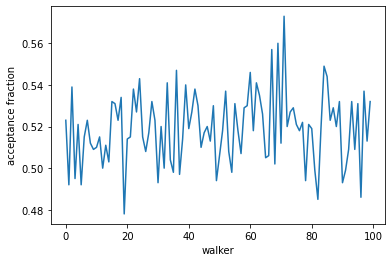

Figure B.1: Acceptance fraction for each walker (should be around 0.5)


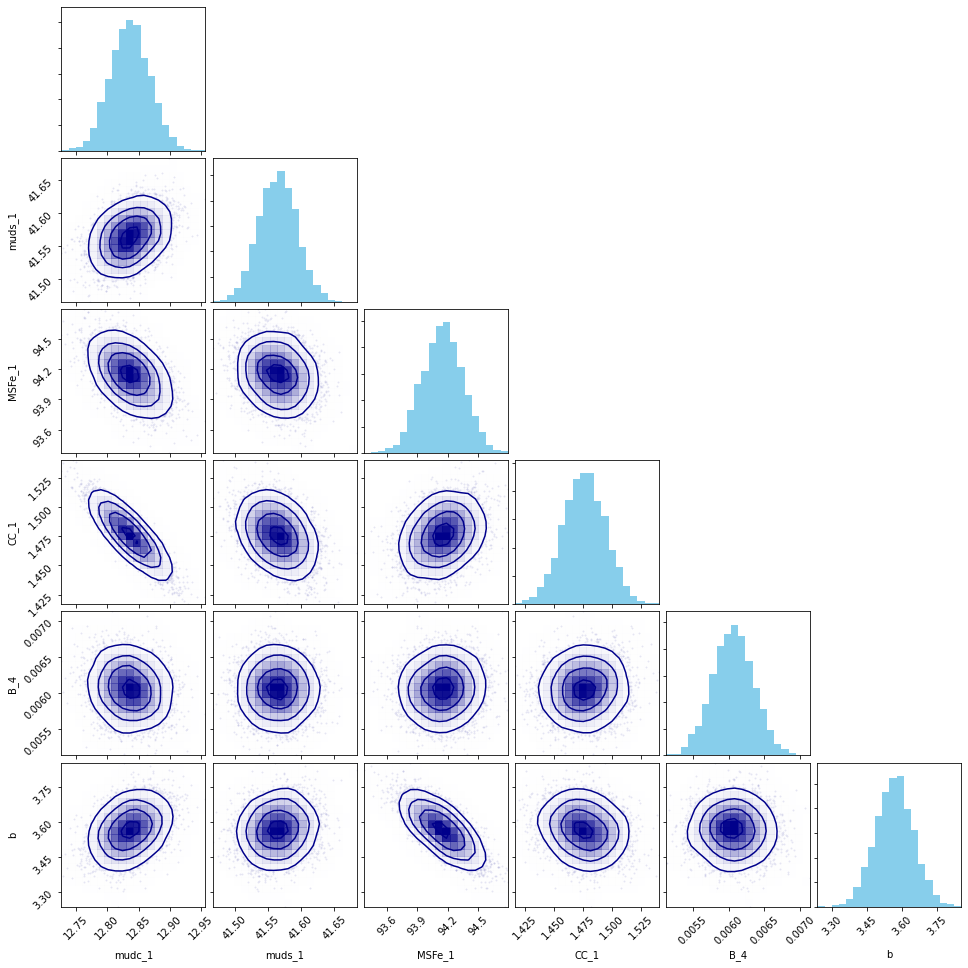

Figure B.2: corner plot of the parameter distributions and cross correlations (Bayes fit)


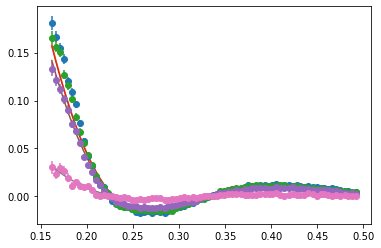

Figure B.3: plot of SANS data and fit (Bayes fit)


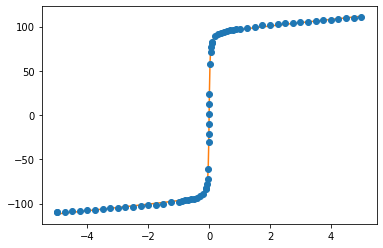

Figure B.4: plot of DCMdata and fit (Bayes fit)


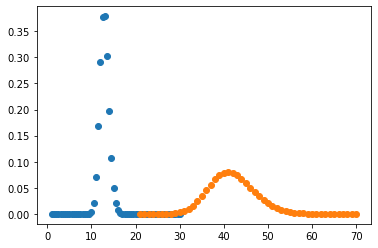

Figure B.5: lognormal distribution of core (blue) and total particle (orange) size (Bayes fit)


In [2]:
#==============================================================================
#==============================================================================
# B) Bayes fit
#==============================================================================
#==============================================================================
# B.1) Fit of data

nwalkers=100 # should be set that it is much larger than number of parameters/variables. 100 is default
steps=1000 # number of samples you would like to draw from the posterior distribution for each of the walkers
burn=300 # Discard this many samples from the start of the sampling regime.
thin=20 # Only accept 1 in every thin samples.
params=res1.params # we use the fit results of the leastsq fit as starting values for the refinement

res2 = lm.minimize(objective, method='emcee', nan_policy='omit', nwalkers=nwalkers, steps=steps, burn=burn, thin=thin, 
                   params=params, is_weighted=True, progress=True)

lm.report_fit(res2.params)

#==============================================================================
# B.2) Plot of results

plt.plot(res2.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()
print('Figure B.1: Acceptance fraction for each walker (should be around 0.5)')

# corner plot
emcee_plot = corner.corner(res2.flatchain, labels=res2.var_names, color ='darkblue', truth_color='black',smooth=True,hist_kwargs=dict(histtype='stepfilled', color='skyblue'))
plt.show()
print('Figure B.2: corner plot of the parameter distributions and cross correlations (Bayes fit)')

plt.figure()
for i in range(N):
    y_fit = residuals(res2.params, i)
    plt.errorbar(q,data[i,:],sddata[i,:], marker='o', ls='None', label='Observed')
    plt.plot(q,y_fit)
plt.show() 
print('Figure B.3: plot of SANS data and fit (Bayes fit)')

plt.errorbar(Bm,m,sdm, marker='o', ls='None', label='Observed')
plt.plot(Bm,residuals2(res2.params))
plt.show()
print('Figure B.4: plot of DCMdata and fit (Bayes fit)')

plt.plot(dc,lognor(dc,res2.params['sigmadc_1'].value,res2.params['mudc_1'].value),'o')
plt.plot(ds,lognor(ds,res2.params['sigmads_1'].value,res2.params['muds_1'].value),'o')
plt.show()
print('Figure B.5: lognormal distribution of core (blue) and total particle (orange) size (Bayes fit)')
